In [1]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('dataset.csv',index_col=0)

# Prepare data

In [4]:
int_cols = df.select_dtypes(include=['int', 'float']).columns
int_cols = int_cols.drop('target_game_currency')
obj_cols = ['country','network_name','sex','is_cheater','has_email']

In [5]:
def prepare_obj_data(df, obj_cols):
    '''
    Подготовка колонрк с типом данных object
    
    Arg:
        df: pd.DataFrame
        obj_col: str 
    Return:
        pd.DataFrame
    '''
    label_encoder = LabelEncoder()
    for column in df[obj_cols]:
        encoded_column = label_encoder.fit_transform(df[column])
        new_column_name = column + "_level"
        df[new_column_name] = encoded_column
    df.drop(obj_cols,axis=1,inplace=True)
        
    return df

In [6]:
df = prepare_obj_data(df, obj_cols)

In [7]:
df.drop(['date_install','first_command_time','birthday','time_confirm_email'],axis=1,inplace=True)

In [8]:
X = df.drop('target_game_currency', axis = 1)
y = df['target_game_currency']

In [9]:
y_stratified = (y > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y_stratified, random_state=42)


## Catboost

In [10]:
def plot_importance(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.feature_importances_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [11]:
def SMAPE(y_true, y_pred):
    """
    SMAPE score
    """
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.where(denominator == 0, 0, 2 * np.abs(y_true - y_pred) / denominator)
    return np.mean(diff)


def custom_smape_score(estimator, X, y):
    '''
    SMAP for cross-validation
    '''
    y_pred = estimator.predict(X)
    smape = SMAPE(y, y_pred)
    return -smape

In [17]:
def train_model(model_obj, X_train, y_train, num_folds ,cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train, verbose=100))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = custom_smape_score)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

0:	learn: 9026.8710114	total: 12.4ms	remaining: 3.69s
100:	learn: 7392.9767616	total: 980ms	remaining: 1.93s
200:	learn: 7215.5323586	total: 1.8s	remaining: 885ms
299:	learn: 7121.1821305	total: 2.53s	remaining: 0us
0:	learn: 9297.2059214	total: 6.76ms	remaining: 2.02s
50:	learn: 7688.0969501	total: 329ms	remaining: 1.61s
100:	learn: 7409.2064794	total: 649ms	remaining: 1.28s
150:	learn: 7284.6248123	total: 973ms	remaining: 960ms
200:	learn: 7192.3366216	total: 1.28s	remaining: 633ms
250:	learn: 7148.3434910	total: 1.6s	remaining: 313ms
299:	learn: 7098.7833852	total: 1.95s	remaining: 0us
0:	learn: 9618.3754072	total: 19.9ms	remaining: 5.95s
50:	learn: 8045.3535102	total: 478ms	remaining: 2.33s
100:	learn: 7821.5670935	total: 932ms	remaining: 1.83s
150:	learn: 7708.1454754	total: 1.44s	remaining: 1.42s
200:	learn: 7623.1276676	total: 1.78s	remaining: 877ms
250:	learn: 7566.6363739	total: 2.17s	remaining: 423ms
299:	learn: 7528.1269344	total: 2.57s	remaining: 0us
0:	learn: 8399.9524692	

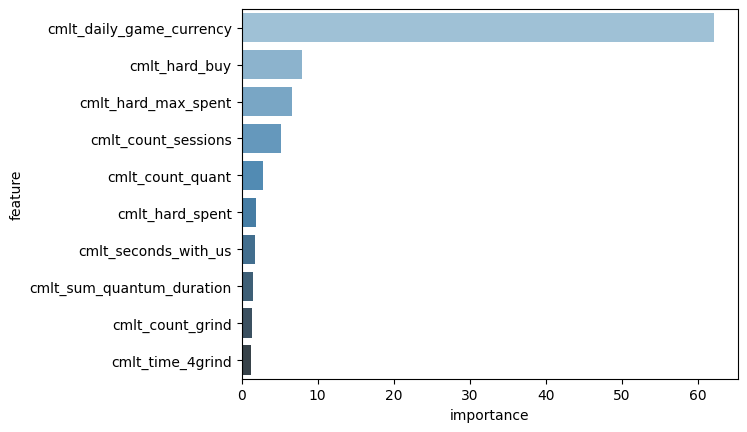

In [146]:
params = {
    'iterations': 300,
    'learning_rate': 0.05,
    'depth': 4,
    'loss_function': 'RMSE',
    'random_state': 42,
    'l2_leaf_reg': 10,
    'verbose': 50
}

model, features = train_model(CatBoostRegressor(**params),
                              X_train, 
                              y_train,
                              5,
                              cross_val=True)

In [147]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [148]:
print('Train SMAPE: ', SMAPE(y_train, y_pred_train))
print('Test SMAPE: ', SMAPE(y_test, y_pred_test))

print('Train RMSE: ',  np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('Test RMSE: ',  np.sqrt(mean_squared_error(y_test, y_pred_test)))

print('Train MSE: ',  mean_absolute_error(y_train, y_pred_train))
print('Test MSE: ',  mean_absolute_error(y_test, y_pred_test))

Train SMAPE:  1.9722899849283162
Test SMAPE:  1.9724160900175145
Train RMSE:  7121.182130602498
Test RMSE:  7515.540533600365
Train MSE:  626.8145723391088
Test MSE:  659.3878060038518
